In [27]:
import numpy as np
import matplotlib.pyplot as plt

import pickle # To load reference solution

import torch
from torch import nn

In [28]:
# Setting devices
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(device)

cpu


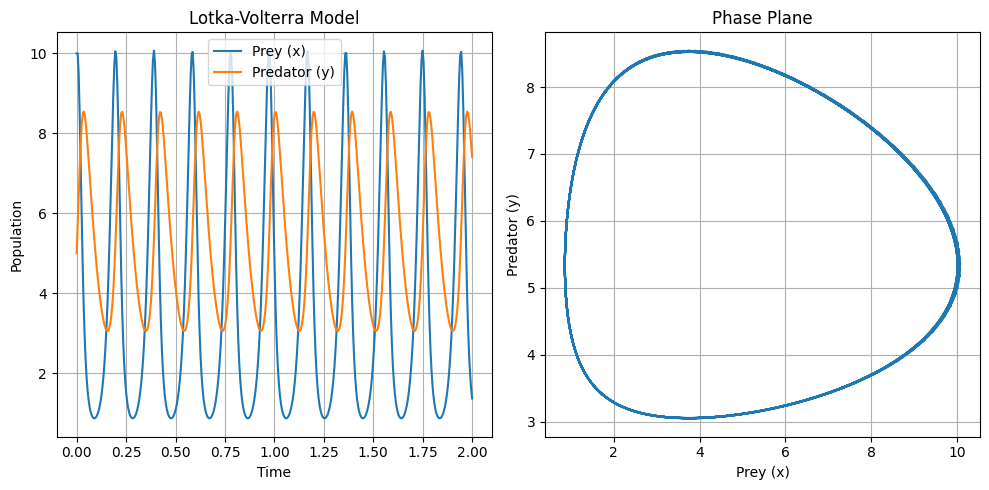

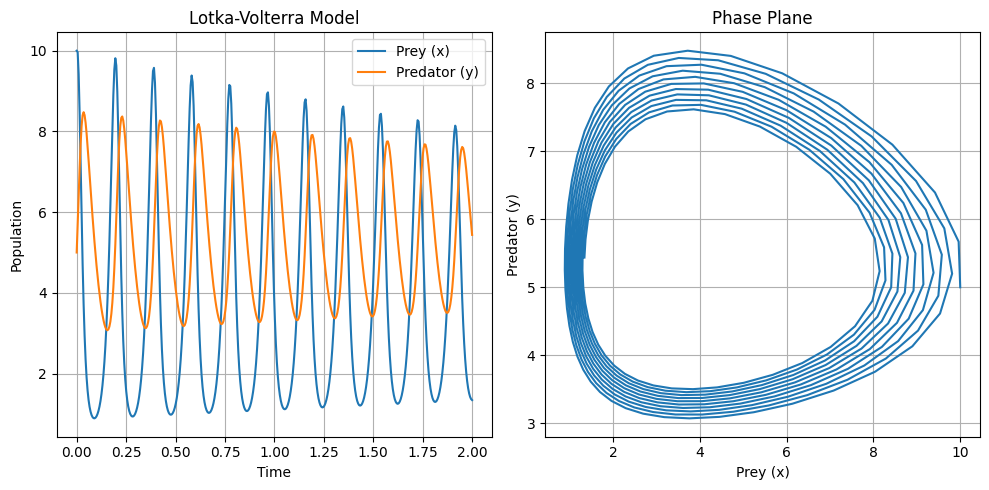

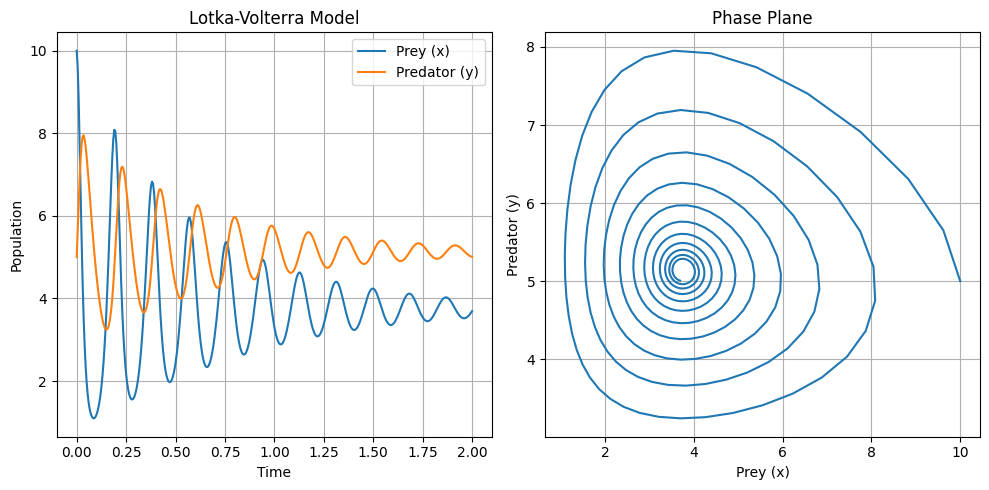

In [29]:
with open("ref_data.pkl", "rb") as f:
    data = pickle.load(f)

alpha = data['alpha']   # Prey birth rate
beta  = data['beta']    # Predation rate
gamma = data['gamma']   # Predator death rate
delta = data['delta']   # Predator reproduction rate

K_vals = data['K_vals']
t      = data['t']
z0     = data['IC']

for i,K in enumerate(K_vals):

    sol = data[K]
    x = sol[:, 0]
    y = sol[:, 1]

    # Plot results
    plt.figure(figsize=(10, 5))

    # Time series
    plt.subplot(1, 2, 1)
    plt.plot(t, x, label='Prey (x)')
    plt.plot(t, y, label='Predator (y)')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Lotka-Volterra Model')
    plt.legend()
    plt.grid(True)

    # Phase plot
    plt.subplot(1, 2, 2)
    plt.plot(x, y)
    plt.xlabel('Prey (x)')
    plt.ylabel('Predator (y)')
    plt.title('Phase Plane')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from fourier_attn import FourierAttn
from torch.nn import MSELoss
pinn_model = FourierAttn()

def loss_fn(t, model, alpha, beta, gamma, delta, z0):
    output = model(t)
    x = output[:, 0:1] 
    y = output[:, 1:2] 
    
    # Compute time derivatives
    x_t = torch.autograd.grad(
        outputs=x.sum(),  # Sum to get scalar for gradient
        inputs=t,
        create_graph=True,
        retain_graph=True)[0]  # This gives (N, 1)
    
    y_t = torch.autograd.grad(
        outputs=y.sum(),  # Sum to get scalar for gradient
        inputs=t,
        create_graph=True,
        retain_graph=True)[0]  # This gives (N, 1)

    z0_x = torch.tensor(z0[0], device=x.device, dtype=x.dtype)
    z0_y = torch.tensor(z0[1], device=y.device, dtype=y.dtype)

    mse_loss = MSELoss()
    x_loss = mse_loss(x_t, alpha * x * (1-K*x) - beta * x * y)
    y_loss = mse_loss(y_t, gamma * y - delta * y * x)
    x_boundary_loss = mse_loss(x[0], z0_x)
    y_boundary_loss = mse_loss(y[0], z0_y)
    return x_loss + y_loss + x_boundary_loss + y_boundary_loss


In [31]:
from tqdm import tqdm

"""
alpha = data['alpha']   # Prey birth rate
beta  = data['beta']    # Predation rate
gamma = data['gamma']   # Predator death rate
delta = data['delta']   # Predator reproduction rate

K_vals = data['K_vals']
t      = data['t']
z0     = data['IC']
"""

optim = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.9)
scaler = torch.amp.GradScaler()

epochs = 200
K = 0.001
train_data = torch.tensor(t, dtype=torch.float32, device=device).reshape(-1, 1)
train_data = train_data.requires_grad_(True)
for i in tqdm(range(epochs), desc="Training Epochs"):
    optim.zero_grad()
    with torch.cuda.amp.autocast(enabled=True):
        loss = loss_fn(train_data, pinn_model, alpha, beta, gamma, delta, z0)
    # compute gradients of training loss
    loss.backward()
    scaler.step(optim)
    scaler.update()
    scheduler.step()
    print(f"Epoch {i+1}, Loss: {loss.item()}")

Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/6c/_3svmfsx1lsbvzqgmjxy74sw0000gn/T/ipykernel_52467/3454362741.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/Users/jma2/brin-sciml/venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([400, 1, 2])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Epochs:   0%|          | 0/200 [00:08<?, ?it/s]


AttributeError: 'int' object has no attribute 'size'